# Dimensionality reduction on session features

In [1]:

""" 
IMPORTS
"""
import os
import autograd.numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.cluster import KMeans
import umap
from sklearn import mixture

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from postprocessing_functions import trial_relative_frequency
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from data_processing import save_and_log
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/4_Clustering//'
os.chdir(functions_path)
from clustering_functions import GMM_log_likelihood

from one.api import ONE
one = ONE(mode='remote')

## Get data

In [2]:
# Full file path for dumping
file_path = os.path.join('/home/ines/repositories/representation_learning_variability/Exported figures/COSYNE25/')
file_path = os.path.join('/home/ines/repositories/representation_learning_variability/Exported figures/')

# DATA used for COSYNE: states_trial_type_14oct2024

In [3]:
# Load trial clsuters
results_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
filename = str(results_path + 'cluster_per_trial01-09-2025')
trial_clusters = pd.read_parquet(filename, engine='pyarrow')

### Frequency of trial types per mouse

In [9]:
vars = ['mouse_name', 'session', 'cluster']

count, freq_df = trial_relative_frequency(trial_clusters, vars)

## Prepare design matrix

In [19]:
var_names = freq_df.reset_index().keys()[2:]

ori_X = np.array(freq_df[var_names]) #.values

print(np.shape(ori_X))

(215, 6)


## UMAP

In [20]:
repeats = 10
components = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])

### Test for different random seeds

Text(0, 0.5, 'Negative log likelihood (SEM)')

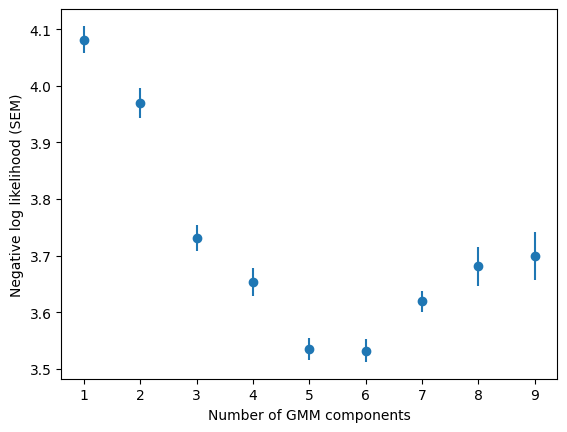

In [21]:
LLs = np.zeros((repeats, len(components))) * np.nan
for r in range(repeats):    
    
    reducer = umap.UMAP(n_components=2)  # Allow for random seed on each iteration
    # reducer = umap.UMAP(random_state= 42, n_components=2)

    # Standardization using StandardScaler
    scaler = StandardScaler()
    standardized_X = scaler.fit_transform(ori_X)

    # embedding = reducer.fit_transform(standardized_X)
    # embedding.shape

    mouse_embedding = reducer.fit_transform(ori_X)
    mouse_embedding.shape
    
    # Compute log likelihood of a GMM model with different components
    LLs[r, :] = GMM_log_likelihood(mouse_embedding, components)
    
plt.errorbar(components, np.mean(LLs, axis=0), np.std(LLs, axis=0)/np.sqrt(repeats), linestyle='None', marker='o')
plt.xlabel('Number of GMM components')
plt.ylabel('Negative log likelihood (SEM)')
# plt.savefig(file_path+'NLL_mice.svg', format="svg")


### Test for different min_dist 

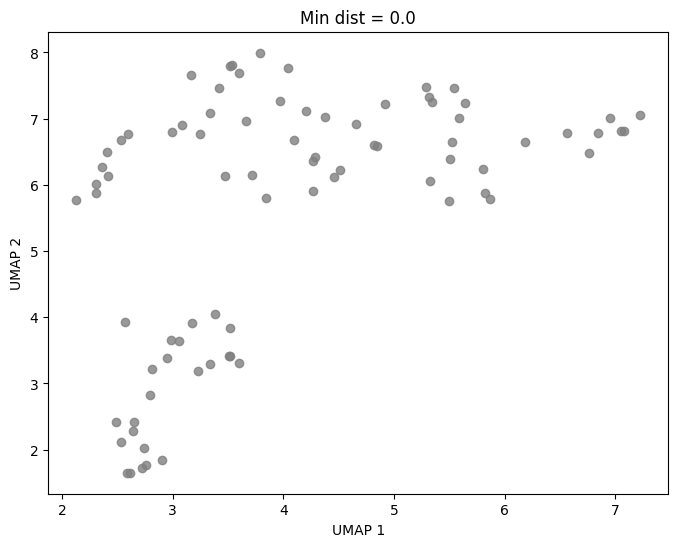

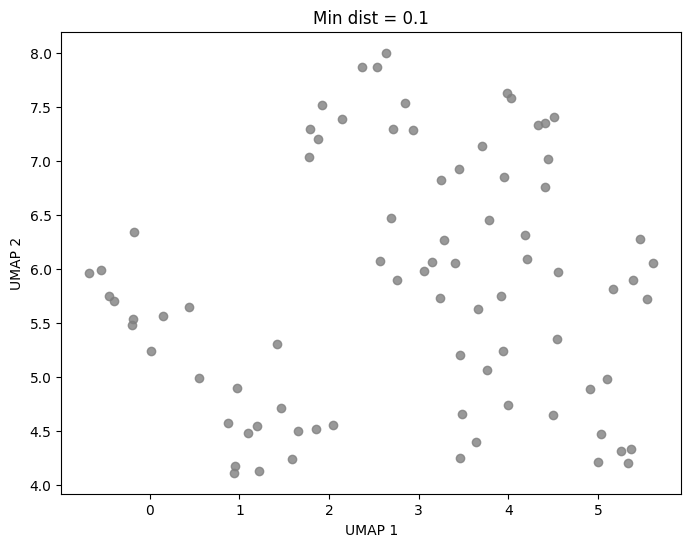

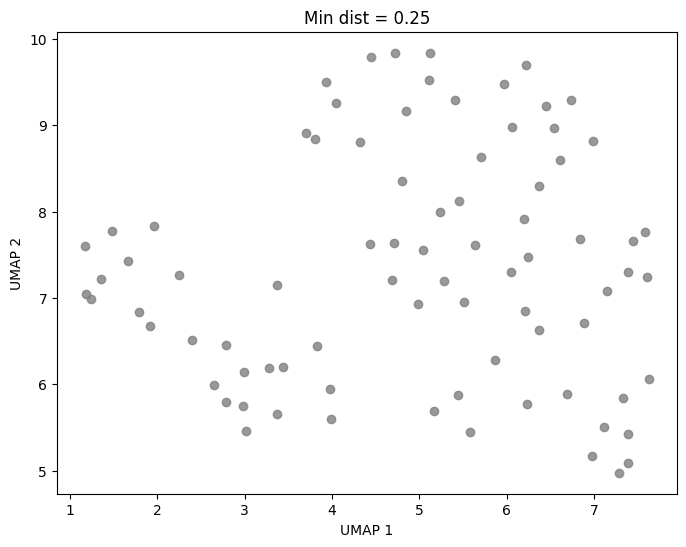

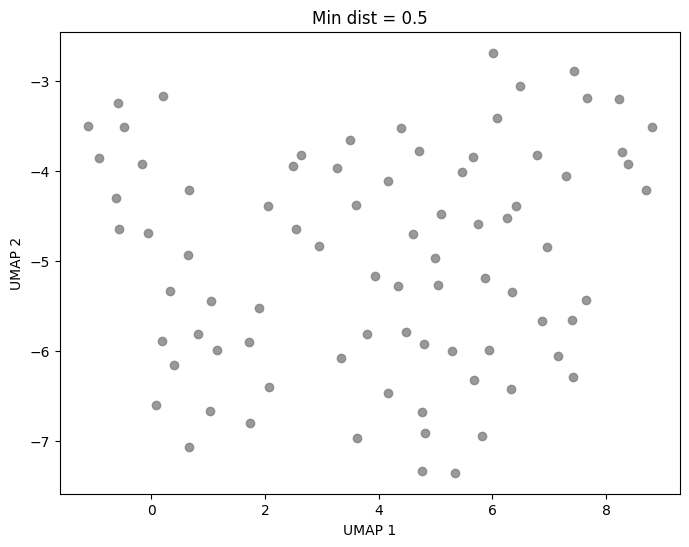

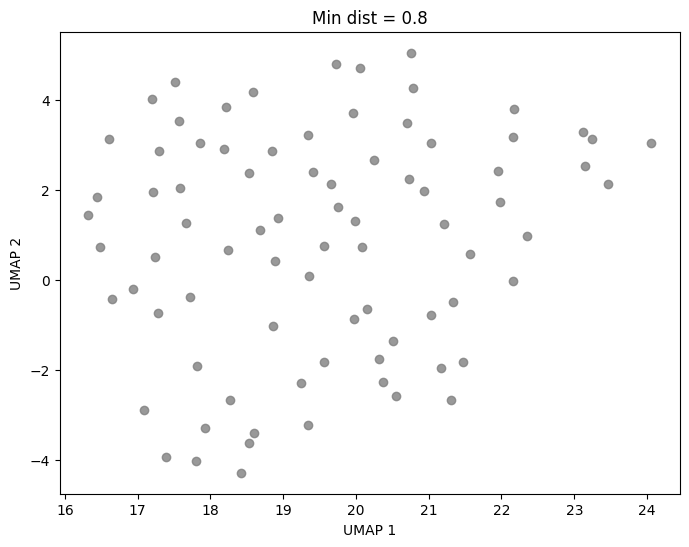

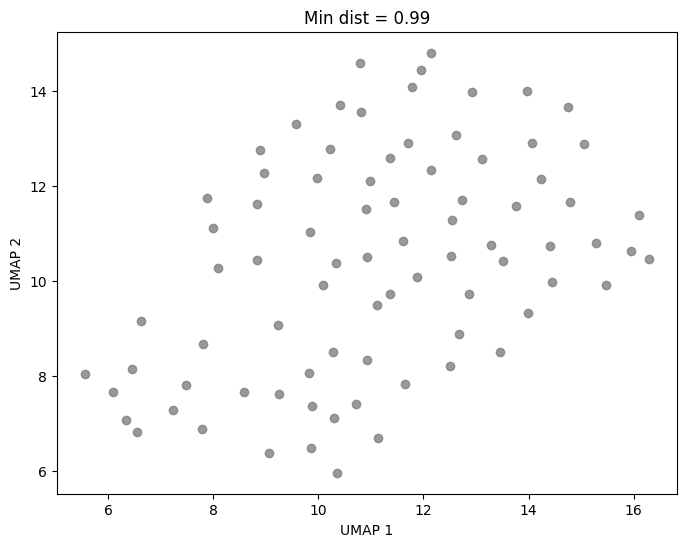

Text(0, 0.5, 'Minimum distance')

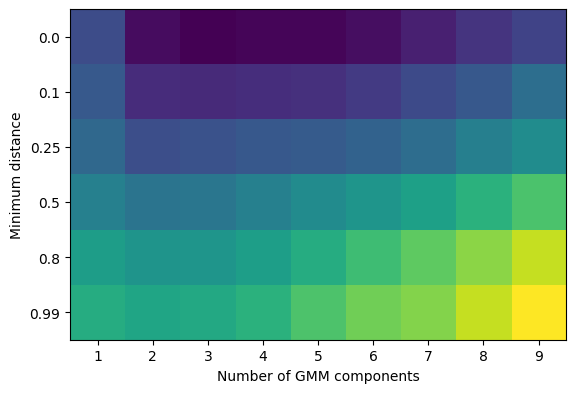

In [105]:
min_dists = np.array([0.0, 0.1, 0.25, 0.5, 0.8, 0.99]) 
LL_min_dist = np.zeros((len(min_dists), len(components))) * np.nan

for d, min_dist in enumerate(min_dists):    
    LLs = np.zeros((repeats, len(components))) * np.nan
    
    for r in range(repeats):  
        
        reducer = umap.UMAP(n_components=2, min_dist=min_dist)  # Allow for random seed on each iteration

        # Standardization using StandardScaler
        scaler = StandardScaler()
        standardized_X = scaler.fit_transform(ori_X)

        mouse_embedding = reducer.fit_transform(ori_X)
        mouse_embedding.shape
        
        # Compute log likelihood of a GMM model with different components
        LLs[r, :] = GMM_log_likelihood(mouse_embedding, components)
    
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        mouse_embedding[:, 0],
        mouse_embedding[:, 1],
        alpha=0.8,
        c='grey'  # Choose a colormap
    )  
    plt.title(str('Min dist = '+str(min_dist)))
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.show()
    
    # Compute log likelihood of a GMM model with different components
    LL_min_dist[d, :] = np.mean(LLs, axis=0)
    
plt.imshow(LL_min_dist)
plt.yticks([0, 1, 2, 3, 4, 5], min_dists)
plt.xticks(np.arange(0, len(components), 1), components)
# plt.errorbar(components, np.mean(LLs, axis=0), np.std(LLs, axis=0)/np.sqrt(len(min_dists)), linestyle='None', marker='o')
plt.xlabel('Number of GMM components')
plt.ylabel('Minimum distance')
# plt.savefig(file_path+'NLL_mice.svg', format="svg")

### Test for different n_neighbours

In [22]:

n_neighbours = np.array([2, 5, 10, 20]) 
LL_neighbours = np.zeros((len(n_neighbours), len(components))) * np.nan

for n, n_neighbour in enumerate(n_neighbours):    
    LLs = np.zeros((repeats, len(components))) * np.nan
    
    for r in range(repeats):  
        
        reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbour)  # Allow for random seed on each iteration

        # Standardization using StandardScaler
        scaler = StandardScaler()
        standardized_X = scaler.fit_transform(ori_X)

        mouse_embedding = reducer.fit_transform(ori_X)
        mouse_embedding.shape
        
        # Compute log likelihood of a GMM model with different components
        LLs[r, :] = GMM_log_likelihood(mouse_embedding, components)
    
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        mouse_embedding[:, 0],
        mouse_embedding[:, 1],
        alpha=0.8,
        c='grey'  # Choose a colormap
    )  
    plt.title(str('N neighbour = '+str(n_neighbour)))
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.show()
    
    # Compute log likelihood of a GMM model with different components
    LL_neighbours[n, :] = np.mean(LLs, axis=0)
    
plt.imshow(LL_neighbours)
plt.yticks([0, 1, 2, 3], n_neighbours)
plt.xticks(np.arange(0, len(components), 1), components)
# plt.errorbar(components, np.mean(LLs, axis=0), np.std(LLs, axis=0)/np.sqrt(len(min_dists)), linestyle='None', marker='o')
plt.xlabel('Number of GMM components')
plt.ylabel('N neighbors')
# plt.savefig(file_path+'NLL_mice.svg', format="svg")

KeyboardInterrupt: 

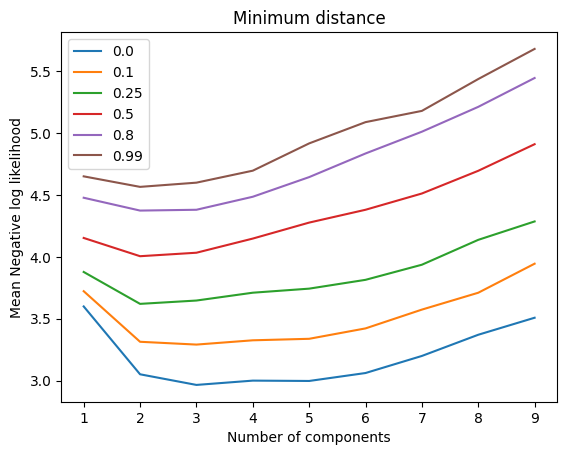

Text(0.5, 1.0, 'N neighbours')

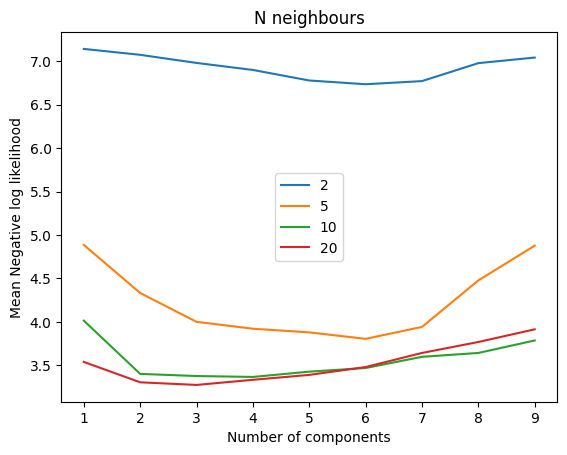

In [107]:
for d, dist in enumerate(min_dists):
    plt.plot(components, LL_min_dist[d, :], label=dist)
plt.legend()
plt.xlabel('Number of components')
plt.ylabel('Mean Negative log likelihood')
plt.title('Minimum distance')
plt.show()

for n, neighbor in enumerate(n_neighbours):
    plt.plot(components, LL_neighbours[n, :], label=neighbor)
plt.legend()
plt.xlabel('Number of components')
plt.ylabel('Mean Negative log likelihood')
plt.title('N neighbours')
    

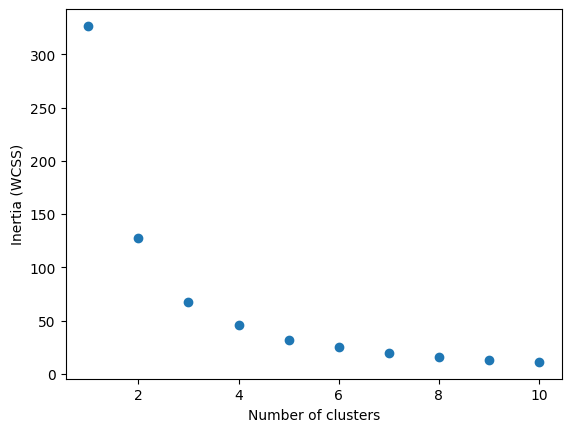

In [12]:
# Assuming `X` is your data
inertia_values = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cutoff = int(np.shape(mouse_embedding)[0]*0.8)
    X_train = np.vstack([mouse_embedding[:cutoff, 0], mouse_embedding[:cutoff, 1]]).T
    kmeans.fit(X_train)
    inertia_values.append(kmeans.inertia_)

# Plotting the inertia values
plt.scatter(K, inertia_values, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (WCSS)')
# plt.title('Elbow Method for Optimal k  - mice')
plt.savefig(file_path+'inertia_mice.svg', format="svg")

plt.show()

## Run UMAP with fixed random seed

In [34]:
reducer = umap.UMAP(random_state= 42, n_components=2)

# Standardization using StandardScaler
scaler = StandardScaler()
standardized_X = scaler.fit_transform(ori_X)

session_embedding = reducer.fit_transform(ori_X)
session_embedding.shape


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(215, 2)

## K-means clustering of data

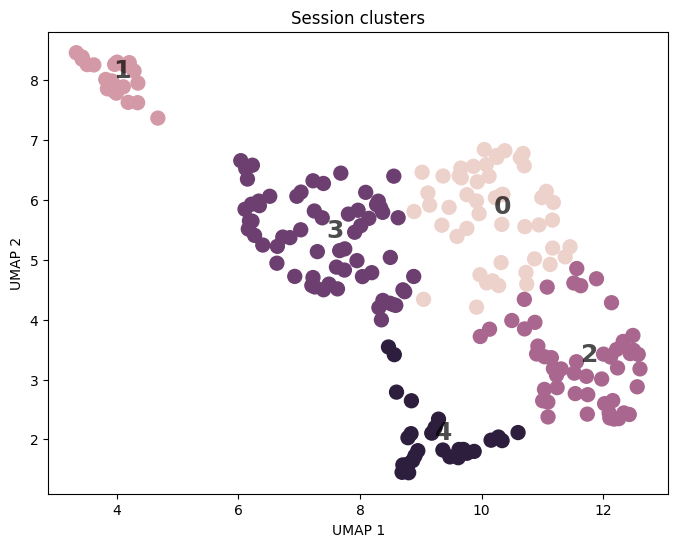

In [37]:
# Step 2: Perform KMeans Clustering
data_2d = session_embedding
kmeans = KMeans(n_clusters=5, random_state=2024)
kmeans.fit(data_2d)
session_y_kmeans = kmeans.predict(data_2d)

# Step 3: Plot the clusters
fig, ax = plt.subplots(figsize=(8, 6))

# Plot each cluster with a different color
scatter = ax.scatter(data_2d[:, 0], data_2d[:, 1], c=session_y_kmeans, s=100, alpha=1, cmap=sns.cubehelix_palette(as_cmap=True))#, edgecolor='black',  cmap=sns.cubehelix_palette(as_cmap=True))


centroids = kmeans.cluster_centers_
for c, cent in enumerate(centroids):
    dots = ax.text(centroids[c, 0], centroids[c, 1], str(c), c='black', alpha=0.7, fontsize=18, weight='bold')

plt.title("Session clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.savefig(file_path+'umap_mice.svg', format="svg")

plt.show()

## Save mouse clusters data

In [39]:
save_df = freq_df.copy()

save_df['UMAP1'] = session_embedding[:, 0]
save_df['UMAP2'] = session_embedding[:, 1]

save_df['session_cluster'] = session_y_kmeans
session_clustered_info = count.reset_index()
session_clustered_info = session_clustered_info.merge(save_df.reset_index()[['mouse_name', 'session', 'session_cluster',
                                                                         'UMAP1', 'UMAP2']], on='mouse_name')

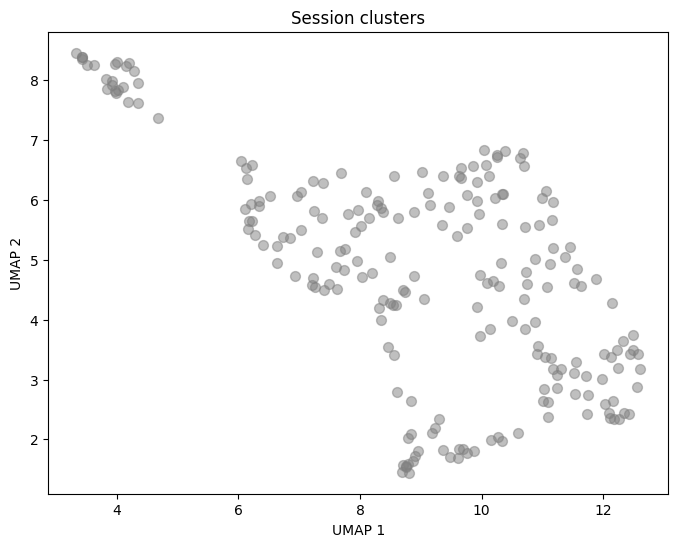

In [46]:
# Step 2: Perform KMeans Clustering
data_2d = session_embedding
kmeans = KMeans(n_clusters=5, random_state=2024)
kmeans.fit(data_2d)
session_y_kmeans = kmeans.predict(data_2d)

# Step 3: Plot the clusters
fig, ax = plt.subplots(figsize=(8, 6))

# Plot each cluster with a different color
scatter = ax.scatter(data_2d[:, 0], data_2d[:, 1],  c='grey', s=50, alpha=.5)#, edgecolor='black',  cmap=sns.cubehelix_palette(as_cmap=True))

plt.title("Session clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.savefig(file_path+'umap_mice.svg', format="svg")

plt.show()

In [50]:
mouse_mean = pd.DataFrame(save_df.groupby(['mouse_name'])['UMAP1', 'UMAP2'].mean()).reset_index()


/tmp/ipykernel_47441/2053531297.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mouse_mean = pd.DataFrame(save_df.groupby(['mouse_name'])['UMAP1', 'UMAP2'].mean()).reset_index()


Text(0, 0.5, 'UMAP 2')

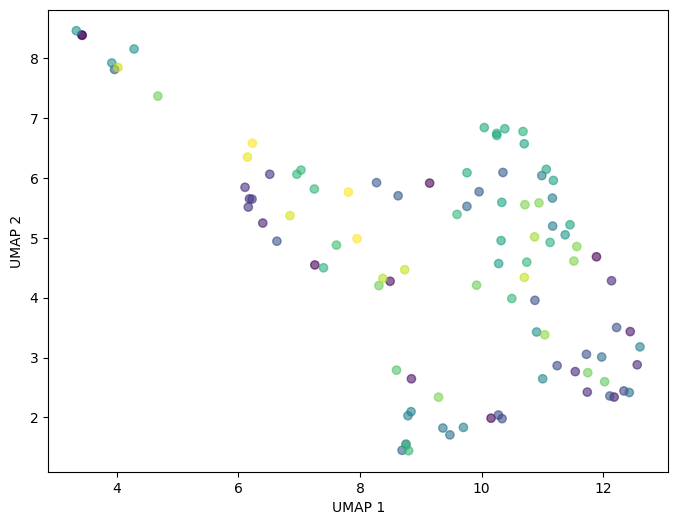

In [63]:
plt.figure(figsize=(8, 6))

# Plot all sessions
# Mouse names in number for color code
unique_mouse_labels = np.arange(0, len(save_df.reset_index()['mouse_name'].unique()), 1)
map_mouse_names = dict(zip(save_df.reset_index()['mouse_name'].unique(), unique_mouse_labels))
mouse_name_numbers = save_df.reset_index()['mouse_name'].map(map_mouse_names)


scatter = plt.scatter(
    session_embedding[:, 0][0:100],
    session_embedding[:, 1][0:100],
    alpha=0.6,
    c=mouse_name_numbers[0:100],
    cmap='viridis'  # Choose a colormap
)   #     c=mouse_name_numbers,

# Create the custom legend
handles = []
for code, label in zip(unique_mouse_labels[:], session_clustered_info['mouse_name'].unique()[:]):
    handles.append(plt.Line2D([], [], marker='o', color=scatter.cmap(scatter.norm(code)), linestyle='', label=label))


# plt.legend(handles=handles, title="Mouse ID", bbox_to_anchor=(1.1, 1.05))
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

Text(0, 0.5, 'UMAP 2')

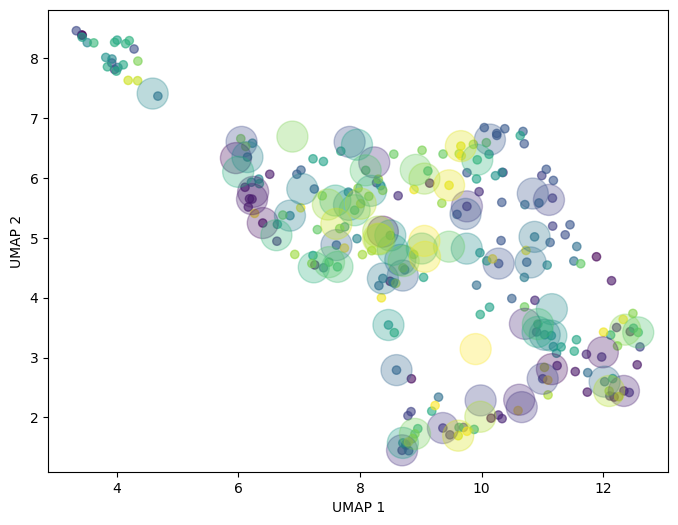

In [60]:
plt.figure(figsize=(8, 6))

# Plot all sessions
# Mouse names in number for color code
unique_mouse_labels = np.arange(0, len(save_df.reset_index()['mouse_name'].unique()), 1)
map_mouse_names = dict(zip(save_df.reset_index()['mouse_name'].unique(), unique_mouse_labels))
mouse_name_numbers = save_df.reset_index()['mouse_name'].map(map_mouse_names)


scatter = plt.scatter(
    session_embedding[:, 0],
    session_embedding[:, 1],
    alpha=0.6,
    c=mouse_name_numbers,
    cmap='viridis'  # Choose a colormap
)   #     c=mouse_name_numbers,

# Create the custom legend
handles = []
for code, label in zip(unique_mouse_labels[:], session_clustered_info['mouse_name'].unique()[:]):
    handles.append(plt.Line2D([], [], marker='o', color=scatter.cmap(scatter.norm(code)), linestyle='', label=label))


# Plot average of sessions per mouse
avg_mouse_name_numbers = mouse_mean.reset_index()['mouse_name'].map(map_mouse_names)
scatter = plt.scatter(
    mouse_mean['UMAP1'],
    mouse_mean['UMAP2'],
    alpha=0.3,
    c=avg_mouse_name_numbers,
    cmap='viridis',
    s=500# Choose a colormap
)   #     c=mouse_name_numbers,

# Create the custom legend
handles = []
for code, label in zip(unique_mouse_labels[:], session_clustered_info['mouse_name'].unique()[:]):
    handles.append(plt.Line2D([], [], marker='o', color=scatter.cmap(scatter.norm(code)), linestyle='', label=label))


# plt.legend(handles=handles, title="Mouse ID", bbox_to_anchor=(1.1, 1.05))
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

In [11]:
file_to_save = session_clustered_info.copy()
filename = "cluster_per_session"
save_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
file_format = 'parquet'
metadata = save_and_log(file_to_save, filename, file_format, save_path)